In [1]:
import pandas as pd
import numpy as np
import collections
from  sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler      #Single-layer perceptron
from sklearn.neural_network import MLPClassifier #Multilayer perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,classification_report, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
import seaborn as sns

In [2]:
import os
import socket
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import types as T, functions as F, SparkSession
from pyspark.sql.window import Window
from pyspark import StorageLevel
from jinja2 import Environment, FileSystemLoader
import datetime
import json

LOGIN = "kzaharov-369865"  # Your gateway.st login
APP_NAME = "2"  # Any name for your Spark-app

NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_').replace(' ', '_').replace('\\', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = (
    "-Dlog4j.configuration=file://{} "
    "-Dspark.hadoop.dfs.replication=1 "
    "-Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"
    .format(LOG4J_PROP_FILE)
)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template.stream(logfile=LOG_FILE).dump(LOG4J_PROP_FILE)


spark = (
    SparkSession
    .builder
    .appName(APP_NAME)
    
    # Master URI/configuration
    .master("k8s://https://10.32.7.103:6443")
    
    .config("spark.driver.host", LOCAL_IP)
    
    # Web-UI port for your Spark-app
    .config("spark.ui.port", "4040")
    .config("spark.driver.bindAddress", "0.0.0.0")
    
    # How many CPU cores allocate to driver process
    .config("spark.driver.cores", "2")
    
    # How many RAM allocate to driver process
    .config("spark.driver.memory", "4g")
    
    # How many executors to create
    .config("spark.executor.instances", "3")
    
    # How many CPU cores allocate to each executor
    .config("spark.executor.cores", '2')
    
    # How many RAM allocate to each executor
    .config("spark.executor.memory", "4g")
    
    # How many extra RAM allocate to each executor pod to handle with JVM overheads
    # Total pod RAM = 'spark.executor.memory' + ('spark.executor.memory' * 'spark.kubernetes.memoryOverheadFactor')
    .config("spark.kubernetes.memoryOverheadFactor", "0.2")
    
    # How many RAM from the pool allocate to store the data
    # Additional info: https://spark.apache.org/docs/latest/tuning.html#memory-management-overview
    .config("spark.memory.fraction", "0.6")
    .config("spark.memory.storageFraction", "0.5")
    
    .config("spark.network.timeout", "180s")
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)
    
    # Namespace to create executor pods. You are allowed to create pods only in your own namespace
    .config("spark.kubernetes.namespace", LOGIN)
    
    # Extra labels to your driver/executor pods in Kubernetes
    .config("spark.kubernetes.driver.label.appname", APP_NAME)
    .config("spark.kubernetes.executor.label.appname", APP_NAME)
    
    # Spark executor image
    .config("spark.kubernetes.container.image", f"node03.st:5000/spark-executor:{LOGIN}")

    .config("spark.kubernetes.container.image.pullPolicy", "Always")
    
    # If true - delete completed/failed pods. 
    # If your executors goes down you can set 'false' to check logs and troubleshoot your app.
    .config("spark.kubernetes.executor.deleteOnTermination", "true")
    
    .config("spark.local.dir", "/tmp/spark")
    .getOrCreate()
)

In [259]:
data = spark.read.csv('/home/kzaharov-369865/matches.csv', header=True, inferSchema=True)

In [260]:
# data = pd.read_csv("/content/matches.csv").set_index(['team_id','season_id','play_id_g','homeAway_g','winner_g'])
# data

In [261]:
data = data.toPandas()

In [262]:
data = data.set_index(['team_id','season_id','play_id_g','homeAway_g','winner_g'])

In [263]:
pre = data[[i for i in data.columns if not
 i.startswith("statistics.splits.categories")
 and not i.startswith("statisticslog")
 and not i.startswith("venue")
 and not i.endswith("ahlete")
 and not i.startswith("collegeAthlete")
 and not i.endswith("athlete")
 and i not in ['Unnamed: 0',
               'order',
               'play_id',
               'date',
               'position.parent.id',
#                'age',
               'record.total.streak',
              'alternateIds.sdr',
              'debutYear',
#               'height',
#               'jersey',
              'position.parent.id',
#               'weight',
               'id',
              'position.id',
              'status.id',
              'Active',
              'Questionable',
              'type_id',
              'college.shortName',
              'dateOfBirth',
              'draft.displayText',
              'draft.displayText',
              'draft.pick.tradeNote',
              'draft.team.start.season',
              'firstName',
              'position.name',
              'position.parent.abbreviation',
              'slug',
              'status.abbreviation',
              'team.start.season',
              'name',
              'nextCompetition',
              'previousCompetition',
              ]

 ]]

In [264]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13619 entries, (1, 2018, 401030691, 'home', True) to (34, 2022, 401437891, 'away', False)
Columns: 784 entries, age_p to name_t
dtypes: bool(2), float64(770), int32(6), object(6)
memory usage: 81.4+ MB


In [265]:
df = pre.select_dtypes(exclude=['object']).reset_index()
df

,team_id,season_id,play_id_g,homeAway_g,winner_g,age_p,alternateIds.sdr_p,height_p,weight_p,OTLosses_t,...,linescore_3_g,linescore_4_g,experience.years_p,id_p,position.id_p,Active_t,Questionable_t,order_g,active_p,draft.pick.traded_p
0,1,2018,401030691,home,True,34.0,2465933.0,74.0,230.0,1.0,...,7.0,7.0,2,16190,29,71,3,0,False,False
1,1,2018,401030826,away,True,34.0,2465933.0,74.0,230.0,1.0,...,7.0,10.0,2,16190,29,71,3,1,False,False
2,1,2018,400999179,away,False,34.0,2465933.0,74.0,230.0,1.0,...,0.0,0.0,2,16190,29,71,3,1,False,False
3,1,2018,401030895,away,True,34.0,2465933.0,74.0,230.0,1.0,...,14.0,0.0,2,16190,29,71,3,1,False,False
4,1,2018,401030973,away,False,34.0,2465933.0,74.0,230.0,1.0,...,0.0,0.0,2,16190,29,71,3,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13614,34,2022,401437813,home,False,32.0,2512500.0,74.0,232.0,1.0,...,0.0,7.0,3,17220,30,70,7,0,False,False
13615,34,2022,401437819,home,False,32.0,2512500.0,74.0,232.0,1.0,...,3.0,0.0,3,17220,30,70,7,0,False,False
13616,34,2022,401437848,home,False,32.0,2512500.0,74.0,232.0,1.0,...,3.0,7.0,3,17220,30,70,7,0,False,False
13617,34,2022,401437637,home,False,32.0,2512500.0,74.0,232.0,1.0,...,10.0,0.0,3,17220,30,70,7,0,False,False


In [268]:
df['active_p'] = df['active_p'].replace({False: 0, True: 1})
df['draft.pick.traded_p'] = df['draft.pick.traded_p'].replace({False: 0, True: 1})

In [269]:
matches=pd.DataFrame(df[['team_id','season_id','play_id_g','homeAway_g','winner_g']]).set_index(['team_id','season_id'])
matches

play_id_g homeAway_g  winner_g
team_id season_id                                
1       2018       401030691       home      True
        2018       401030826       away      True
        2018       400999179       away     False
        2018       401030895       away      True
        2018       401030973       away     False
...                      ...        ...       ...
34      2022       401437813       home     False
        2022       401437819       home     False
        2022       401437848       home     False
        2022       401437637       home     False
        2022       401437891       away     False

[13619 rows x 3 columns]

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13619 entries, 0 to 13618
Columns: 783 entries, team_id to draft.pick.traded_p
dtypes: bool(1), float64(770), int32(6), int64(5), object(1)
memory usage: 81.0+ MB


In [271]:
agg_cols=list(filter(lambda x: x!='play_id_g' and  x!='homeAway_g'  , df.columns.tolist()))

In [272]:
agg_df=df.groupby(['team_id','season_id']).mean().drop(labels=['play_id_g','winner_g'],axis=1)
agg_df

age_p  alternateIds.sdr_p  height_p  weight_p  OTLosses_t  \
team_id season_id                                                              
1       2018        34.0           2465933.0      74.0     230.0         1.0   
        2019        34.0           2465933.0      74.0     230.0         0.0   
        2020        34.0           2465933.0      74.0     230.0         0.0   
        2022        34.0           2465933.0      74.0     230.0         0.0   
2       2000        34.0           2310931.5      74.0     235.0         1.0   
...                  ...                 ...       ...       ...         ...   
34      2017        32.0           2512500.0      74.0     232.0         0.0   
        2018        32.0           2512500.0      74.0     232.0         0.0   
        2019        32.0           2512500.0      74.0     232.0         0.0   
        2020        32.0           2512500.0      74.0     232.0         1.0   
        2022        32.0           2512500.0      74.0     232.0         1.0   

                   OTWins_t  avgPointsAgainst_t  avgPointsFor_t  \
team_id season_id                                                 
1       2018            0.0           26.437500       25.875000   
        2019            1.0           24.937500       23.812500   
        2020            0.0           25.875000       24.750000   
        2022            1.0           22.705883       21.470589   
2       2000            2.0           21.875000       19.687500   
...                     ...                 ...             ...   
34      2017            0.0           27.250000       21.125000   
        2018            2.0           19.750000       25.125000   
        2019            0.0           24.062500       23.625000   
        2020            0.0           29.000000       24.000000   
        2022            0.0           24.705883       17.000000   

                   differential_t  divisionWinPercent_t  ...  linescore_3_g  \
team_id season_id                                        ...                  
1       2018                 -9.0              0.666667  ...       3.545455   
        2019                -18.0              0.666667  ...       3.333333   
        2020                -18.0              0.166667  ...       3.157895   
        2022                -21.0              0.333333  ...       4.750000   
2       2000                -35.0              0.250000  ...       1.700000   
...                           ...                   ...  ...            ...   
34      2017                -98.0              0.166667  ...       3.913043   
        2018                 86.0              0.666667  ...       3.300000   
        2019                 -7.0              0.666667  ...       4.523810   
        2020                -80.0              0.333333  ...       3.714286   
        2022               -131.0              0.583333  ...       4.750000   

                   linescore_4_g  experience.years_p     id_p  position.id_p  \
team_id season_id                                                              
1       2018            6.545455                 2.0  16190.0           29.0   
        2019            8.000000                 2.0  16190.0           29.0   
        2020            5.105263                 2.0  16190.0           29.0   
        2022            5.250000                 2.0  16190.0           29.0   
2       2000            6.650000                 3.0  15354.0           30.0   
...                          ...                 ...      ...            ...   
34      2017            5.260870                 3.0  17220.0           30.0   
        2018            6.450000                 3.0  17220.0           30.0   
        2019            7.476190                 3.0  17220.0           30.0   
        2020            5.666667                 3.0  17220.0           30.0   
        2022            4.800000                 3.0  17220.0           30.0   

                   Active_t  Question

In [273]:
df_joined = agg_df.join(matches).reset_index()

In [274]:
cols=pd.DataFrame(data.columns)

In [275]:
plays=matches['play_id_g'].value_counts()
plays=plays.loc[ lambda x : x>1].index.tolist()

In [276]:
X=df_joined.drop(labels=['team_id','season_id','play_id_g','winner_g','homeAway_g'],axis=1)
y=df_joined['winner_g']

In [277]:
corr_matrix = X.corr(method = "spearman").abs()

# Draw the heatmap
# sns.set(font_scale = 1.0)
# f, ax = plt.subplots(figsize=(11, 9))
# sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
# f.tight_layout()
# plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

<ipython-input-277-14764188ee05>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))


In [278]:
# Найдем индексы фич с коэф корреляции более 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# # Drop features
# importances_corr = X.drop(to_drop, axis = 1)
# importances_corr_cols= importances_corr.columns.tolist()

In [279]:
X_diff_array_dropped=[]
y=[]
team=0
for play in plays:
    team= df_joined.drop(to_drop, axis = 1)[(df_joined['play_id_g']==play)&(df_joined['homeAway_g']=='home')]
    guest= df_joined.drop(to_drop, axis = 1)[(df_joined['play_id_g']==play)&(df_joined['homeAway_g']=='away')]


    diff = [a - b for a, b in zip(team.drop(labels=['team_id','season_id','play_id_g','winner_g','homeAway_g'],axis=1).values,
                                guest.drop(labels=['team_id','season_id','play_id_g','winner_g','homeAway_g'],axis=1).values)]
    X_diff_array_dropped.append(diff)
    if (team['winner_g'].values): y.append(1)
    else: y.append(0)

In [290]:
X_diff_array_dropped=np.array(X_diff_array_dropped).reshape((np.shape(X_diff_array_dropped)[0],\
                                                             np.shape(X_diff_array_dropped)[2]))

<Figure size 2160x4320 with 0 Axes>

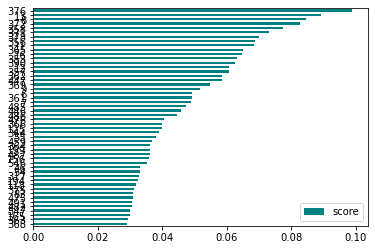

In [291]:
importances = mutual_info_classif(X_diff_array_dropped, y)
plt.figure(figsize=(30,60))
feature_importances = pd.DataFrame(data={'score':importances}).sort_values(by='score',ascending=True)
feature_importances.tail(50).plot(kind='barh', color='teal')
feature_IG=feature_importances.sort_values(by='score',ascending=False).head(int(0.6*len(feature_importances)))

In [299]:
X_diff_array_dropped.shape

(6140, 557)

In [306]:
df_joined2 = df_joined.drop(to_drop, axis = 1).drop(labels=['team_id','season_id','play_id_g','winner_g','homeAway_g'],axis=1)

In [307]:
df_final=df_joined2.iloc[:,feature_IG.index.tolist()]\
    .join(df_joined[['team_id','play_id_g','winner_g','homeAway_g']])
df_final

,record.total.streak_g,points_t,differential_t,record.total.losses_g,record.road.losses_g,record.total.leaguewinpercent_g,record.total.value_g,record.home.value_g,leagueWinPercent_t,record.total.differential_g,...,statistics.miscellaneous.totalPlays_g,fumbleRecoveries_rank_t,OTLosses_t,statistics.receiving.receivingFumbles_g,statistics.miscellaneous.totalPenalties_g,statistics.miscellaneous.totalPenaltyYards_g,team_id,play_id_g,winner_g,homeAway_g
0,-0.818182,-1.0,-9.0,4.909091,2.636364,0.412636,0.310863,0.464394,0.583333,-2.727273,...,13.181818,1.0,1.0,0.272727,6.272727,56.863636,1,401030691,True,home
1,-0.818182,-1.0,-9.0,4.909091,2.636364,0.412636,0.310863,0.464394,0.583333,-2.727273,...,13.181818,1.0,1.0,0.272727,6.272727,56.863636,1,401030826,True,away
2,-0.818182,-1.0,-9.0,4.909091,2.636364,0.412636,0.310863,0.464394,0.583333,-2.727273,...,13.181818,1.0,1.0,0.272727,6.272727,56.863636,1,400999179,False,away
3,-0.818182,-1.0,-9.0,4.909091,2.636364,0.412636,0.310863,0.464394,0.583333,-2.727273,...,13.181818,1.0,1.0,0.272727,6.272727,56.863636,1,401030895,True,away
4,-0.818182,-1.0,-9.0,4.909091,2.636364,0.412636,0.310863,0.464394,0.583333,-2.727273,...,13.181818,1.0,1.0,0.272727,6.272727,56.863636,1,401030973,False,away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13614,-2.300000,-5.0,-131.0,5.900000,3.200000,0.227229,0.322299,0.332421,0.291667,-4.900000,...,58.500000,4.0,1.0,0.000000,5.450000,45.200000,34,401437813,False,home
13615,-2.300000,-5.0,-131.0,5.900000,3.200000,0.227229,0.322299,0.332421,0.291667,-4.900000,...,58.500000,4.0,1.0,0.000000,5.450000,45.200000,34,401437819,False,home
13616,-2.300000,-5.0,-131.0,5.900000,3.200000,0.227229,0.322299,0.332421,0.291667,-4.900000,...,58.500000,4.0,1.0,0.000000,5.450000,45.200000,34,401437848,False,home
13617,-2.300000,-5.0,-131.0,5.900000,3.200000,0.227229,0.322299,0.332421,0.291667,-4.900000,...,58.500000,4.0,1.0,0.000000,5.450000,45.200000,34,401437637,False,home


In [325]:
X_diff_array_dropped_final=[]
y=[]
team=0
for play in plays:
    team= df_final[(df_joined['play_id_g']==play)&(df_joined['homeAway_g']=='home')]
    guest= df_final[(df_joined['play_id_g']==play)&(df_joined['homeAway_g']=='away')]


    diff = [a - b for a, b in zip(team.drop(labels=['team_id','play_id_g','winner_g','homeAway_g'],axis=1).values,
                                guest.drop(labels=['team_id','play_id_g','winner_g','homeAway_g'],axis=1).values)]
    X_diff_array_dropped_final.append(diff)
    if (team['winner_g'].values): y.append(1)
    else: y.append(0)

In [326]:
X_diff_array_dropped_final=np.array(X_diff_array_dropped_final).reshape((np.shape(X_diff_array_dropped_final)[0],\
                                                                         np.shape(X_diff_array_dropped_final)[2]))

X_train, X_test, y_train, y_test = train_test_split(X_diff_array_dropped_final, y,\
                                                            test_size = 0.4, random_state = 5555, shuffle=True)
# X_val, X_test, y_val, y_test= train_test_split(X_test_val, y_test_val, test_size = 0.3,\
#                                                             random_state = 0, shuffle=True)
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
# X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

# Spark ML

In [341]:
from pyspark.ml.classification import GBTClassifier, LogisticRegression, LinearSVC

In [328]:
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline

In [329]:
cols = np.arange(X_train_std[0].shape[0]).astype(str)
cols = np.append(cols, 'label')

In [330]:
data_train = pd.DataFrame(np.concatenate([X_train_std, np.array(y_train).reshape(-1, 1)], axis=1), columns=cols)
data_test = pd.DataFrame(np.concatenate([X_test_std, np.array(y_test).reshape(-1, 1)], axis=1), columns=cols)

In [331]:
vector_assembler = VectorAssembler(inputCols=cols[:-1], outputCol='features')

In [332]:
pipeline = Pipeline().setStages([vector_assembler])

In [333]:
data_train_spark = spark.createDataFrame(data_train)
data_test_spark = spark.createDataFrame(data_test)

In [334]:
model_va = pipeline.fit(data_train_spark)
df_features_train =  model_va.transform(data_train_spark)
df_features_test = model_va.transform(data_test_spark)

In [347]:
model_gbt = GBTClassifier(featuresCol="features", labelCol='label', maxIter = 80, maxDepth=3)
gbt = model_gbt.fit(df_features_train.select('features', 'label'))

In [348]:
prediction_spark_gbt = gbt.transform(df_features_test)

In [349]:
prediction_spark_ar_gbt = prediction_spark_gbt.select('prediction').toPandas().values

In [350]:
prediction_spark_prob_gbt = prediction_spark_gbt.select('probability')

probs_gbt = []
for i in prediction_spark_prob_gbt.toPandas().values[:, 0]:
    probs_gbt.append(i[1])
    
prediction_spark_prob_gbt = probs_gbt

In [351]:
prediction_spark_ar_gbt

array([[1.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [358]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [359]:
paramGrid = ParamGridBuilder().addGrid(model_gbt.maxDepth, np.arange(2, 7, 2))\
    .addGrid(model_gbt.maxIter, np.arange(40, 100, 30))\
    .build()

In [360]:
crossval = CrossValidator(estimator=model_gbt, estimatorParamMaps=paramGrid,\
                          evaluator=BinaryClassificationEvaluator(), numFolds=3)

In [ ]:
cvGBT = crossval.fit(df_features_train.select('features', 'label'))

In [ ]:
prediction_spark_cvgbt = cvGBT.transform(df_features_test)

In [ ]:
prediction_spark_ar_cvgbt = prediction_spark_cvgbt.select('prediction').toPandas().values

In [ ]:
print(classification_report(prediction_spark_ar_cvgbt, y_test))

In [ ]:
prediction_spark_ar_gbt

In [ ]:
prediction_spark_cvgbt.columns

### Logistic Regression

In [353]:
model_lr = LogisticRegression(featuresCol="features", labelCol='label', maxIter = 500,\
                              regParam=1, elasticNetParam=0.0)
lr = model_lr.fit(df_features_train.select('features', 'label'))

In [354]:
prediction_spark_lr = lr.transform(df_features_test)
prediction_spark_ar_lr = prediction_spark_lr.select('prediction').toPandas().values

In [355]:
prediction_spark_prob_lr = prediction_spark_lr.select('probability')

probs_lr = []
for i in prediction_spark_prob_lr.toPandas().values[:, 0]:
    probs_lr.append(i[1])
    
prediction_spark_prob_lr = probs_lr

In [ ]:
paramGrid = ParamGridBuilder().addGrid(model_gbt.regParam, np.linspace(0.0001, 2, 20))\
    .addGrid(model_gbt.maxIter, np.arange(40, 100, 20))\
    .build()

In [ ]:
crossval_lr = CrossValidator(estimator=model_lr, estimatorParamMaps=paramGrid,\
                          evaluator=BinaryClassificationEvaluator(), numFolds=3)

In [ ]:
cvlr = crossval_lr.fit(df_features_train.select('features', 'label'))

In [ ]:
prediction_spark_cvlr = cvlr.transform(df_features_test)

In [ ]:
prediction_spark_ar_lr = prediction_spark_cvlr.select('prediction').toPandas().values

In [356]:
print(classification_report(prediction_spark_ar_lr, y_test))

              precision    recall  f1-score   support

         0.0       0.59      0.68      0.63       955
         1.0       0.77      0.71      0.74      1501

    accuracy                           0.70      2456
   macro avg       0.68      0.69      0.69      2456
weighted avg       0.70      0.70      0.70      2456



In [357]:
prediction_spark_ar_lr

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

### Linear SVC

In [342]:
model_svc = LinearSVC(featuresCol="features", labelCol='label', maxIter = 100,\
                              regParam=0.1)
svc = model_svc.fit(df_features_train.select('features', 'label'))

In [343]:
prediction_spark_svc = svc.transform(df_features_test)
prediction_spark_ar_svc = prediction_spark_svc.select('prediction').toPandas().values

In [ ]:
paramGrid = ParamGridBuilder().addGrid(model_gbt.regParam, np.linspace(0.0001, 2, 20))\
    .addGrid(model_gbt.maxIter, np.arange(40, 100, 20))\
    .build()

crossval_svc = CrossValidator(estimator=model_svc, estimatorParamMaps=paramGrid,\
                          evaluator=BinaryClassificationEvaluator(), numFolds=3)

cvsvc = crossval_svc.fit(df_features_train.select('features', 'label'))

In [ ]:
prediction_spark_svc = cvsvc.transform(df_features_test)
prediction_spark_ar_svc = prediction_spark_svc.select('prediction').toPandas().values

In [344]:
print(classification_report(prediction_spark_ar_svc, y_test))

              precision    recall  f1-score   support

         0.0       0.59      0.65      0.62       989
         1.0       0.75      0.70      0.72      1467

    accuracy                           0.68      2456
   macro avg       0.67      0.67      0.67      2456
weighted avg       0.68      0.68      0.68      2456

